In [1]:
from DCTDimReducer import DCTDimReducer
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import utils
import random

dataset = 'CIFAR10'

if dataset == 'MNIST':
    _, _, data, y_test = utils.load_mnist(normalize=True)
    size = 28
elif dataset == 'FMNIST':
    _, _, data, _ = utils.load_fashion_mnist(normalize=True)
    size = 28
elif dataset == 'GRAY_CIFAR10':
    _, _, data, _ = utils.load_cifar10(normalize=True, grayscale=True)
    size = 32
elif dataset == 'CIFAR10':
    _, _, data, _ = utils.load_cifar10(normalize=True)
    size = 32

def visualize_dct(data, size, n, sample_idx='random', adversarial=False, eps=.3):
    # Generate random sample index if one is not provided
    if sample_idx == 'random':
        sample_idx = random.randrange(0, data.shape[0])
    
    # Give the selected sample a batch index
    data = np.expand_dims(data[sample_idx], 0)
    
    if adversarial: # Generate adversarial data
        model = utils.load_VGG('trained_models/' + dataset + '_model.pt')
        model.eval()
        dataloader = utils.create_dataloader(data, np.zeros((data.shape[0]), dtype=int))
        data = utils.add_adversarial_noise(model, dataloader, eps=.3)

    dct = DCTDimReducer(coef_size_reduction=n)
    coefs = dct.fit_transform(data, return_flat=False)
    inverses = dct.inverse_fit_transform(coefs)

    normalize = lambda x : (x - x.min()) / (x.max() - x.min())

    img = np.transpose(normalize(data[0]), (1,2,0))
    coef = coefs.squeeze()
    inv = np.transpose(normalize(inverses[0]), (1,2,0))

    plt.imshow(img)
    plt.show()

    plt.imshow(coef)
    plt.gca().add_patch(Rectangle((size-n, size-n),n,n,linewidth=2,edgecolor='r',facecolor='none'))
    plt.colorbar(fraction=.05, pad=.01)
    plt.show()

    plt.imshow(inv)
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


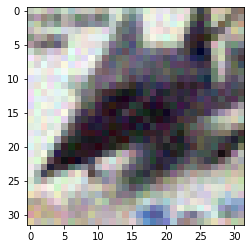

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


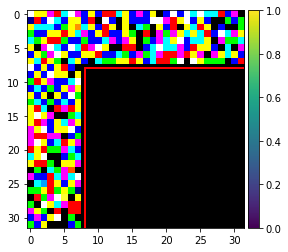

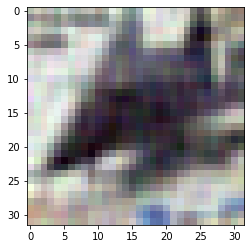

In [11]:
adversarial = True
n = 24
eps = .3

visualize_dct(data, size, n, adversarial=adversarial, eps=eps)

In [9]:
from model import My_VGG as Model
import torch
from torch import nn, optim
from time import time

def train_model(model, optimizer, x_train, x_test, y_train, y_test, epochs=15):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    trainset = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train).type(torch.long))
    valset = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test).type(torch.long))
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

    criterion = nn.NLLLoss()
    
    if device == "cuda":
        model = model.cuda()
    model.train()
    
    time0 = time()
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)
    
    model.eval()
    correct_count, all_count = 0, 0
    for x, y in valloader:
        all_count += y.shape[0]
        x, y = x.to(device), y.to(device)
        output = model(x)
        preds = output.max(1)[1]
        correct_count += preds.eq(y).sum().item()
    model.to("cpu")

    print("Number Of Images Tested =", all_count)
    print("\nModel Accuracy =", (correct_count/all_count))
    
    return model, optimizer

In [11]:
channels = 1
size = 28
classes = 10

# # Create model and optimizer
# model = Model(in_channels=channels, in_size=in_size, num_classes=num_classes)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Train base model
# epochs = 15
# model, optimizer = train_model(model, optimizer, train_inverses, test_inverses, y_train, y_test, epochs=epochs)

# Save trained model
PATH = 'trained_models/dct_model.pt'

# torch.save({'epoch': epochs,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'in_channels': channels,
#             'in_size': size,
#             'num_classes': classes
#             }, PATH)

model = utils.load_VGG(PATH)

In [12]:
attacked_model = utils.load_VGG('trained_models/initial_model.pt')

test_dataloader = utils.create_dataloader(X_test, y_test)
adv_test_data = utils.add_adversarial_noise(attacked_model, test_dataloader, eps=.04)

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [13]:
dct_adv_test_data = dct.fit_transform(adv_test_data)
inverse_dct_adv_test_data = idct.fit_transform(dct_adv_test_data).reshape(-1,1,28,28)

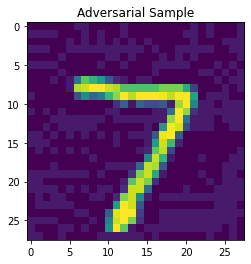

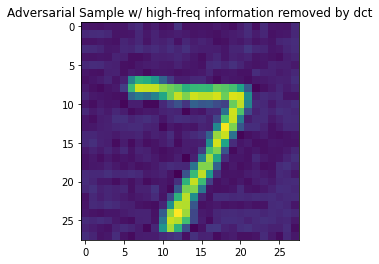

In [14]:
idx = 0

plt.imshow(adv_test_data[idx].squeeze())
plt.title("Adversarial Sample")
plt.show()

plt.imshow(inverse_dct_adv_test_data[idx].squeeze())
plt.title("Adversarial Sample w/ high-freq information removed by dct")
plt.show()

In [15]:
print("Accuracy on plain clean data: %f" % (utils.eval_model(model, X_test, y_test) * 100))
print("Accuracy on dct clean data: %f" % (utils.eval_model(model, test_inverses, y_test) * 100))

print("Accuracy on plain adversarial data: %f" % (utils.eval_model(model, adv_test_data, y_test) * 100))
print("Accuracy on dct adversarial data: %f" % (utils.eval_model(model, inverse_dct_adv_test_data, y_test) * 100))

Accuracy on plain clean data: 99.250000
Accuracy on dct clean data: 99.290000
Accuracy on plain adversarial data: 98.910000
Accuracy on dct adversarial data: 28.440000
